# Example scientific use case

In this notebook, we will attempt to use what we have learn to perform a realistic scientific analysis.

**Note:** The datasets that we are simulating interest in have been chosen to be on the small-ish side (for ABC Atlas), so as not to overwhelm your computer. That being said, this notebook will still end up downloading 25 GB of data to the directory specified in `cache_dir` below. "Small" can only mean so much in the context of the ABC Atlas.

# Scenario

Suppose you are working with ABC Atlas find [this visualization](https://knowledge.brain-map.org/abcatlas#AQIBQVA4Sk5ONUxZQUJHVk1HS1kxQgACUTFOQ1dXUEc2RlowRE5JWEpCUQADAQE0TVY3SEE1REcyWEpaM1VEOEc5AAIBU2VybwAABAEBAnw8w1h%2Fgxq0A4J%2BCQWCVklPAAUABgEBAjRNVjdIQTVERzJYSlozVUQ4RzkAA34AAAAEAAAIRzRJNEdGSlhKQjlBVFozUFRYMQAJTFZEQkpBVzhCSTVZU1MxUVVCRwAKAAsBbm9uZQACbm9uZQADAQQBAAIjMDAwMDAwAAPIAQAFAQECIzAwMDAwMAADyAEAAAABQVA4Sk5ONUxZQUJHVk1HS1kxQgACUTFOQ1dXUEc2RlowRE5JWEpCUQADAQE0TVY3SEE1REcyWEpaM1VEOEc5AAIBU2VybwAABAEBAnw8w1h%2Fgxq0A4J%2BCQWCVklPAAUABgEBAjE1Qks0N0RDSU9GMVNMTFVXOVAAA34AAAAEAAAIRzRJNEdGSlhKQjlBVFozUFRYMQAJTFZEQkpBVzhCSTVZU1MxUVVCRwAKAAsBbm9uZQACbm9uZQADAQQBAAIjMDAwMDAwAAPIAQAFAQECIzAwMDAwMAADyAEAAAACAwA%3D). Both panels select for cells annotated as being serotonergic. The right panel colors them by their supertype in the Whole Mouse Brain taxonomy. It appears that the cells in the Whole Mouse Brain dataset annotated as being serotonergic are made up of 7 supertypes, most of which exist in the same region of the UMAP, but two of which are distinctly separate from the others. You want to know what makes those two separate supertypes ("0893 MB-MY Tph2 Glut-Sero_6" and "0894 MB-MY Tph2 Glut-Sero_7") different from the others.

To answer this question, you will need to download the cell-by-gene data fro the serotonergic cells in the Whole Mouse Brain dataset and perform some kind of statistical analysis on them to determine which genes distinguish those supertypes from the other supertypes.


# Get the libraries you need

In [1]:
import anndata
import h5py
import numpy as np
import os
import pandas as pd
import pathlib
import scipy.sparse

In [2]:
import abc_atlas_access.abc_atlas_cache.abc_project_cache as abc_project_cache

In [3]:
cache_dir = "/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/examples/data/abc_cache"

if not os.path.isdir(cache_dir):
    raise RuntimeError(
        "Set cache_dir above to the path to the directory where you want to download ABC Atlas data"
    )

abc_cache = abc_project_cache.AbcProjectCache.from_cache_dir(cache_dir)

In [4]:
abc_cache.load_latest_manifest()

# Get cell metadata

Recapitulating what we learned about the cell type taxonomy data model, we want to download the `cell_metadata` dataframe and annotate each cell according to its neurotransmitter type and its supertype.

In [5]:
whole_mouse_taxonomy_dir = 'WMB-taxonomy'

In [6]:
whole_mouse_metadata_dir = 'WMB-10X'

Download the full `cell_metadata` table. Truncate it to only include the columns we need to identify cells and the cell-by-gene files they correspond to

In [7]:
whole_mouse_cell_metadata = abc_cache.get_metadata_dataframe(
    directory=whole_mouse_metadata_dir,
    file_name='cell_metadata'
)[['cell_label', 'feature_matrix_label', 'cluster_alias', 'dataset_label']]



Download the dataframe defining the annotation term sets in the Whole Mouse Brain taxonomy

In [8]:
whole_mouse_term_set_df = abc_cache.get_metadata_dataframe(
    directory=whole_mouse_taxonomy_dir,
    file_name='cluster_annotation_term_set'
)

whole_mouse_term_set_df

,label,name,description,order
0,CCN20230722_NEUR,neurotransmitter,Clusters are assigned based on the average exp...,0
1,CCN20230722_CLAS,class,The top level of cell type definition in the m...,1
2,CCN20230722_SUBC,subclass,The coarse level of cell type definition in th...,2
3,CCN20230722_SUPT,supertype,The second finest level of cell type definitio...,3
4,CCN20230722_CLUS,cluster,The finest level of cell type definition in th...,4


Download the table associating clusters with the annotation terms in the taxonomy

In [9]:
whole_mouse_membership_df = abc_cache.get_metadata_dataframe(
    directory=whole_mouse_taxonomy_dir,
    file_name='cluster_to_cluster_annotation_membership'
)

Create a dataframe associating `cluster_alias` with `neurotransmitter`.

In [10]:
neurotransmitter_df = whole_mouse_membership_df[
    whole_mouse_membership_df.cluster_annotation_term_set_label == 'CCN20230722_NEUR'
]

In [11]:
neurotransmitter_df = neurotransmitter_df.rename(
    {'cluster_annotation_term_name': 'neurotransmitter',
     'cluster_annotation_term_label': 'neurotransmitter_label',
     'color_hex_triplet': 'neurotransmitter_color'},
    axis=1
)

In [12]:
neurotransmitter_df = neurotransmitter_df[
    ['cluster_alias',
     'neurotransmitter',
     'neurotransmitter_label',
     'neurotransmitter_color']
]

In [13]:
neurotransmitter_df.head(10)

,cluster_alias,neurotransmitter,neurotransmitter_label,neurotransmitter_color
21288,128,Glut,CS20230722_NEUR_Glut,#2B93DF
21289,129,Glut,CS20230722_NEUR_Glut,#2B93DF
21290,130,Glut,CS20230722_NEUR_Glut,#2B93DF
21291,143,Glut,CS20230722_NEUR_Glut,#2B93DF
21292,131,Glut,CS20230722_NEUR_Glut,#2B93DF
21293,116,Glut,CS20230722_NEUR_Glut,#2B93DF
21294,120,Glut,CS20230722_NEUR_Glut,#2B93DF
21295,121,Glut,CS20230722_NEUR_Glut,#2B93DF
21296,122,Glut,CS20230722_NEUR_Glut,#2B93DF
21297,125,Glut,CS20230722_NEUR_Glut,#2B93DF


Create a dataframe associating `cluster_alias` with `supertype`

In [14]:
supertype_df = whole_mouse_membership_df[
    whole_mouse_membership_df.cluster_annotation_term_set_label == 'CCN20230722_SUPT'
]

In [15]:
supertype_df = supertype_df.rename(
    {'cluster_annotation_term_name': 'supertype',
     'cluster_annotation_term_label': 'supertype_label',
     'color_hex_triplet': 'supertype_color'},
    axis=1
)

In [16]:
supertype_df = supertype_df[
    ['cluster_alias', 
     'supertype',
     'supertype_label',
     'supertype_color']
]

In [17]:
supertype_df.head(10)

,cluster_alias,supertype,supertype_label,supertype_color
5322,128,0001 CLA-EPd-CTX Car3 Glut_1,CS20230722_SUPT_0001,#99822E
5323,129,0001 CLA-EPd-CTX Car3 Glut_1,CS20230722_SUPT_0001,#99822E
5324,130,0001 CLA-EPd-CTX Car3 Glut_1,CS20230722_SUPT_0001,#99822E
5325,143,0001 CLA-EPd-CTX Car3 Glut_1,CS20230722_SUPT_0001,#99822E
5326,131,0002 CLA-EPd-CTX Car3 Glut_2,CS20230722_SUPT_0002,#170F66
5327,116,0003 IT EP-CLA Glut_1,CS20230722_SUPT_0003,#994563
5328,120,0003 IT EP-CLA Glut_1,CS20230722_SUPT_0003,#994563
5329,121,0003 IT EP-CLA Glut_1,CS20230722_SUPT_0003,#994563
5330,122,0003 IT EP-CLA Glut_1,CS20230722_SUPT_0003,#994563
5331,125,0003 IT EP-CLA Glut_1,CS20230722_SUPT_0003,#994563


Join the `cell_metadata` table with the neurotransmitter and supertype dataframes. Truncate the dataframe to only include the columns we will need to grab the cell-by-gene data from the serotonergic cells and associate them with supertypes.

In [18]:
whole_mouse_cell_metadata = whole_mouse_cell_metadata.join(
    neurotransmitter_df.set_index('cluster_alias'),
    on='cluster_alias'
)
whole_mouse_cell_metadata = whole_mouse_cell_metadata.join(
    supertype_df.set_index('cluster_alias'),
    on='cluster_alias'
)
whole_mouse_cell_metadata = whole_mouse_cell_metadata[
    ['cell_label',
     'dataset_label',
     'feature_matrix_label',
     'neurotransmitter',
     'neurotransmitter_label',
     'neurotransmitter_color',
     'supertype',
     'supertype_label',
     'supertype_color']
]

In [19]:
whole_mouse_cell_metadata

,cell_label,dataset_label,feature_matrix_label,neurotransmitter,neurotransmitter_label,neurotransmitter_color,supertype,supertype_label,supertype_color
0,GCGAGAAGTTAAGGGC-410_B05,WMB-10Xv3,WMB-10Xv3-HPF,Glut,CS20230722_NEUR_Glut,#2B93DF,0082 L2 IT PPP-APr Glut_3,CS20230722_SUPT_0082,#266DFF
1,AATGGCTCAGCTCCTT-411_B06,WMB-10Xv3,WMB-10Xv3-HPF,Glut,CS20230722_NEUR_Glut,#2B93DF,0082 L2 IT PPP-APr Glut_3,CS20230722_SUPT_0082,#266DFF
2,AACACACGTTGCTTGA-410_B05,WMB-10Xv3,WMB-10Xv3-HPF,Glut,CS20230722_NEUR_Glut,#2B93DF,0082 L2 IT PPP-APr Glut_3,CS20230722_SUPT_0082,#266DFF
3,CACAGATAGAGGCGGA-410_A05,WMB-10Xv3,WMB-10Xv3-HPF,Glut,CS20230722_NEUR_Glut,#2B93DF,0082 L2 IT PPP-APr Glut_3,CS20230722_SUPT_0082,#266DFF
4,AAAGTGAAGCATTTCG-410_B05,WMB-10Xv3,WMB-10Xv3-HPF,Glut,CS20230722_NEUR_Glut,#2B93DF,0082 L2 IT PPP-APr Glut_3,CS20230722_SUPT_0082,#266DFF
...,...,...,...,...,...,...,...,...,...
4042971,GTGTGAGCAAACGCGA-1350_C05,WMB-10XMulti,WMB-10XMulti,GABA-Glyc,CS20230722_NEUR_GABA-Glyc,#820e57,1074 NLL Gata3 Gly-Gaba_1,CS20230722_SUPT_1074,#a4fcb2
4042972,TTAGCAATCCCTGTTA-1350_C05,WMB-10XMulti,WMB-10XMulti,Glut,CS20230722_NEUR_Glut,#2B93DF,0682 RN Spp1 Glut_1,CS20230722_SUPT_0682,#BA1FCC
4042973,TTTGGCTGTCGCGCAA-1350_C05,WMB-10XMulti,WMB-10XMulti,GABA-Glyc,CS20230722_NEUR_GABA-Glyc,#820e57,1076 NLL Gata3 Gly-Gaba_3,CS20230722_SUPT_1076,#76CC00
4042974,ATCCACCTCACAGACT-1320_B04,WMB-10XMulti,WMB-10XMulti,GABA-Glyc,CS20230722_NEUR_GABA-Glyc,#820e57,1076 NLL Gata3 Gly-Gaba_3,CS20230722_SUPT_1076,#76CC00


# Get cell-by-gene data

Now that we have a `cell_metadata` table that includes columns annotating each cell according to its neurotransmitter and supertype annotation, we need to determine which cells we are actually interested in. Once we have that, we can use what we learned the h5ad tutorial to download and subset the relevant expression data.

First, let's limit ourselves to cells which have been assigned the neurotransmitter annotation "Sero".

In [20]:
sero = whole_mouse_cell_metadata[whole_mouse_cell_metadata.neurotransmitter=='Sero']

Let's see which cell-by-gene files we need to get the expression data for these cells. We do this by creating a dataframe that only contains the `dataset_label` and `feature_matrix_label` columns and dropping any duplicates. Recall that `dataset_label` corresponds to the `directory` kwarg in `abc_cache.get_file_path` and `feature_matrix_label` corresponds to the `file_name` kwarg in `abc_cache.get_file_path`.

In [21]:
files_needed = sero[['dataset_label', 'feature_matrix_label']].drop_duplicates()

In [22]:
files_needed

,dataset_label,feature_matrix_label
262281,WMB-10Xv3,WMB-10Xv3-P
288492,WMB-10Xv3,WMB-10Xv3-MB
288920,WMB-10Xv3,WMB-10Xv3-MY


Thankfully (or, conincidentally, since that is how this notebook was designed), we only need three files. **But those files still take up 25 GB of data which will be downloaded the first time you run this notebook.**

Let's actually do the downloading.

In [23]:
for row in files_needed.iterrows():
    data = row[1]
    abc_cache.get_file_path(
        directory=data['dataset_label'],
        file_name=f"{data['feature_matrix_label']}/log2"
    )

We will now loop over the h5ad files we have downloaded and scrape them for the cells we are actually interested in. We will aggregate those cells into a new `AnnData` object that contains only the serotonergic cells from ABC Atlas. To construct the new `AnnData` object, we will need a `var` dataframe containing metadata about the genes in the data. Let's download the gene metadata from the Whole Mouse Brain data.

In [24]:
gene_metadata = abc_cache.get_metadata_dataframe(
    directory='WMB-10X',
    file_name='gene'
).set_index('gene_identifier')

The cell below actually accomplishes the work of looping over the h5ad files and gathering the desired cells into a new `AnnData` object. We include comments explaining each step in the process.

In [25]:
# create an empty (n_cells, n_genes) array to hold the expression data for all
# of the desired cells
expression_data = np.zeros(
    (len(sero), len(gene_metadata)),
    dtype=float
)

# create a lookup table mapping cell_label to row in the new AnnData object
# (determined by row in the sero dataframe, which will be the obs dataframe
# of the new AnnData object)
dst_cell_to_idx = {
    cell: ii for ii, cell in enumerate(sero.cell_label.values)
}

# loop over all of the files we have downloaded
for dataset_label, feature_matrix_label in zip(files_needed.dataset_label,
                                               files_needed.feature_matrix_label):
    file_name = f'{feature_matrix_label}/log2'
    print(f'reading {dataset_label}/{file_name}')
    src_path = abc_cache.get_file_path(
        directory=dataset_label,
        file_name=file_name
    )

    src = anndata.read_h5ad(src_path, backed='r')

    # make sure that the genes in this file are in the same order as our
    # new var dataframe
    np.testing.assert_array_equal(
        src.var.index.values,
        gene_metadata.index.values
    )

    # create a lookup table mapping cell_label to row number in the
    # raw data we are reading
    src_cell_to_idx = {
        cell: ii for ii, cell in enumerate(src.obs.index.values)
    }

    subset = sero[
        np.logical_and(
            sero.dataset_label==dataset_label,
            sero.feature_matrix_label==feature_matrix_label
        )
    ]

    # array of indices indicating which rows in the src data we want
    src_idx = np.array([src_cell_to_idx[cell] for cell in subset.cell_label])

    # array of indices indicating to which rows in the new AnnDAta the cells
    # from src will map
    dst_idx = np.array([dst_cell_to_idx[cell] for cell in subset.cell_label])

    # populate the relevant rows of expression_data
    expression_data[dst_idx, :] = src[src_idx, :].X.toarray()

    # make sure the src data file is close (anndata isn't great about that)
    src.file.close()
    del src

# create the new AnnDAta object
sero_adata = anndata.AnnData(
    obs=sero.set_index('cell_label'),
    var=gene_metadata,
    X=expression_data
)

# delete the expression_data numpy array
# (which we no longer need)
del expression_data


reading WMB-10Xv3/WMB-10Xv3-P/log2
reading WMB-10Xv3/WMB-10Xv3-MB/log2
reading WMB-10Xv3/WMB-10Xv3-MY/log2


**Congratulations!** we now have an `AnnData` object (`sero_adata`) that contains the metadata and expression data for all the serotonergic cells in the Whole Mouse Brain dataset from ABC Atlas.

We can see the metadata associated with cells here

In [26]:
sero_adata.obs

,dataset_label,feature_matrix_label,neurotransmitter,neurotransmitter_label,neurotransmitter_color,supertype,supertype_label,supertype_color
cell_label,,,,,,,,
AGCCAGCTCGTCAAAC-436_C04,WMB-10Xv3,WMB-10Xv3-P,Sero,CS20230722_NEUR_Sero,#533691,0888 MB-MY Tph2 Glut-Sero_1,CS20230722_SUPT_0888,#1F2E66
AGGAAATTCAGGAAAT-163_A01,WMB-10Xv3,WMB-10Xv3-P,Sero,CS20230722_NEUR_Sero,#533691,0888 MB-MY Tph2 Glut-Sero_1,CS20230722_SUPT_0888,#1F2E66
CTGAGCGCAAATGGTA-196.3_A01,WMB-10Xv3,WMB-10Xv3-P,Sero,CS20230722_NEUR_Sero,#533691,0889 MB-MY Tph2 Glut-Sero_2,CS20230722_SUPT_0889,#00CC06
GAATCACAGCTGACCC-149_C01,WMB-10Xv3,WMB-10Xv3-MB,Sero,CS20230722_NEUR_Sero,#533691,0888 MB-MY Tph2 Glut-Sero_1,CS20230722_SUPT_0888,#1F2E66
CTTCTCTCATTCTCCG-433_C01,WMB-10Xv3,WMB-10Xv3-MB,Sero,CS20230722_NEUR_Sero,#533691,0888 MB-MY Tph2 Glut-Sero_1,CS20230722_SUPT_0888,#1F2E66
...,...,...,...,...,...,...,...,...
TCATGCCAGTGGTGGT-1200_A02,WMB-10Xv3,WMB-10Xv3-P,Sero,CS20230722_NEUR_Sero,#533691,0892 MB-MY Tph2 Glut-Sero_5,CS20230722_SUPT_0892,#B33DCC
TCATTTGGTTGCTCCT-429_A07,WMB-10Xv3,WMB-10Xv3-P,Sero,CS20230722_NEUR_Sero,#533691,0892 MB-MY Tph2 Glut-Sero_5,CS20230722_SUPT_0892,#B33DCC
TCCCACATCAGTGTCA-178_A01,WMB-10Xv3,WMB-10Xv3-MY,Sero,CS20230722_NEUR_Sero,#533691,0892 MB-MY Tph2 Glut-Sero_5,CS20230722_SUPT_0892,#B33DCC


the metadata associated with genes here

In [27]:
sero_adata.var

,gene_symbol,name,mapped_ncbi_identifier,comment
gene_identifier,,,,
ENSMUSG00000051951,Xkr4,X-linked Kx blood group related 4,NCBIGene:497097,NaN
ENSMUSG00000089699,Gm1992,predicted gene 1992,NaN,NaN
ENSMUSG00000102331,Gm19938,"predicted gene, 19938",NaN,NaN
ENSMUSG00000102343,Gm37381,"predicted gene, 37381",NaN,NaN
ENSMUSG00000025900,Rp1,retinitis pigmentosa 1 (human),NCBIGene:19888,NaN
...,...,...,...,...
ENSMUSG00000095523,AC124606.1,PRAME family member 8-like,NCBIGene:100038995,no expression
ENSMUSG00000095475,AC133095.2,uncharacterized LOC545763,NCBIGene:545763,no expression
ENSMUSG00000094855,AC133095.1,uncharacterized LOC620639,NCBIGene:620639,no expression


and the actuall cell-by-gene expression data here

In [28]:
sero_adata.X

array([[10.55566216,  3.8390317 ,  5.35517073, ...,  0.        ,
         0.        ,  8.32399654],
       [ 7.93226337,  0.        ,  6.1395998 , ...,  0.        ,
         0.        ,  7.44919729],
       [ 9.89179802,  0.        ,  5.52953768, ...,  0.        ,
         0.        ,  7.72717857],
       ...,
       [10.23508072,  5.73761606,  7.30443954, ...,  0.        ,
         0.        ,  6.72403336],
       [ 8.95236778,  0.        ,  0.        , ...,  0.        ,
         0.        ,  7.25846624],
       [ 9.45428848,  0.        ,  0.        , ...,  0.        ,
         0.        ,  8.45634365]], shape=(1469, 32285))

# Finding interesting marker genes

Recall that our goal was to determine what makes "0893 MB-MY Tph2 Glut-Sero_6" and "0894 MB-MY Tph2 Glut-Sero_7" different from the other serotonergic supertypes. First, let's create three new `AnnData` objects: one that is just supertype "0893 MB-MY Tph2 Glut-Sero_6", one that is just supertype "0894 MB-MY Tph2 Glut-Sero_7", and one that is every other serotonergic cell.

In [29]:
mask_0893 = (sero_adata.obs.supertype.values == '0893 MB-MY Tph2 Glut-Sero_6')
subset_0893 = sero_adata[mask_0893, :]

subset_0893.obs.head(5)

,dataset_label,feature_matrix_label,neurotransmitter,neurotransmitter_label,neurotransmitter_color,supertype,supertype_label,supertype_color
cell_label,,,,,,,,
CTTCTAACAGGTGGAT-438_C06,WMB-10Xv3,WMB-10Xv3-MB,Sero,CS20230722_NEUR_Sero,#533691,0893 MB-MY Tph2 Glut-Sero_6,CS20230722_SUPT_0893,#993B2E
ATGGAGGAGCCATTTG-1028_B06,WMB-10Xv3,WMB-10Xv3-P,Sero,CS20230722_NEUR_Sero,#533691,0893 MB-MY Tph2 Glut-Sero_6,CS20230722_SUPT_0893,#993B2E
AAGCATCAGGATTTCC-1028_B06,WMB-10Xv3,WMB-10Xv3-P,Sero,CS20230722_NEUR_Sero,#533691,0893 MB-MY Tph2 Glut-Sero_6,CS20230722_SUPT_0893,#993B2E
AGTTCCCTCGAGAATA-167_A01,WMB-10Xv3,WMB-10Xv3-P,Sero,CS20230722_NEUR_Sero,#533691,0893 MB-MY Tph2 Glut-Sero_6,CS20230722_SUPT_0893,#993B2E
AATCGTGTCAGCCTTC-982_A03,WMB-10Xv3,WMB-10Xv3-MB,Sero,CS20230722_NEUR_Sero,#533691,0893 MB-MY Tph2 Glut-Sero_6,CS20230722_SUPT_0893,#993B2E


In [30]:
mask_0894 = (sero_adata.obs.supertype.values == '0894 MB-MY Tph2 Glut-Sero_7')
subset_0894 = sero_adata[mask_0894, :]

subset_0894.obs.head(5)

,dataset_label,feature_matrix_label,neurotransmitter,neurotransmitter_label,neurotransmitter_color,supertype,supertype_label,supertype_color
cell_label,,,,,,,,
CAGTGCGGTCCAGAAG-997_A03,WMB-10Xv3,WMB-10Xv3-MB,Sero,CS20230722_NEUR_Sero,#533691,0894 MB-MY Tph2 Glut-Sero_7,CS20230722_SUPT_0894,#000566
CACCGTTTCTAGTCAG-426_C04,WMB-10Xv3,WMB-10Xv3-P,Sero,CS20230722_NEUR_Sero,#533691,0894 MB-MY Tph2 Glut-Sero_7,CS20230722_SUPT_0894,#000566
GGGTGAAGTCGCAGTC-196.3_A01,WMB-10Xv3,WMB-10Xv3-P,Sero,CS20230722_NEUR_Sero,#533691,0894 MB-MY Tph2 Glut-Sero_7,CS20230722_SUPT_0894,#000566
GCCCAGAAGGACCCAA-166_A01,WMB-10Xv3,WMB-10Xv3-P,Sero,CS20230722_NEUR_Sero,#533691,0894 MB-MY Tph2 Glut-Sero_7,CS20230722_SUPT_0894,#000566
AATTTCCGTGTCCTAA-1028_A06,WMB-10Xv3,WMB-10Xv3-P,Sero,CS20230722_NEUR_Sero,#533691,0894 MB-MY Tph2 Glut-Sero_7,CS20230722_SUPT_0894,#000566


In [31]:
mask_other = np.logical_and(
    np.logical_not(mask_0893),
    np.logical_not(mask_0894)
)

subset_others = sero_adata[mask_other, :]

subset_others.obs.sample(n=5)

,dataset_label,feature_matrix_label,neurotransmitter,neurotransmitter_label,neurotransmitter_color,supertype,supertype_label,supertype_color
cell_label,,,,,,,,
GGTGAAGCAGTGAGCA-433_C01,WMB-10Xv3,WMB-10Xv3-MB,Sero,CS20230722_NEUR_Sero,#533691,0888 MB-MY Tph2 Glut-Sero_1,CS20230722_SUPT_0888,#1F2E66
GAGGCCTCACTTGGCG-149_B01,WMB-10Xv3,WMB-10Xv3-MB,Sero,CS20230722_NEUR_Sero,#533691,0888 MB-MY Tph2 Glut-Sero_1,CS20230722_SUPT_0888,#1F2E66
GCATGATCACGCTGCA-211_B01,WMB-10Xv3,WMB-10Xv3-MB,Sero,CS20230722_NEUR_Sero,#533691,0888 MB-MY Tph2 Glut-Sero_1,CS20230722_SUPT_0888,#1F2E66
TCATTACGTAGTCTTG-982_A03,WMB-10Xv3,WMB-10Xv3-MB,Sero,CS20230722_NEUR_Sero,#533691,0888 MB-MY Tph2 Glut-Sero_1,CS20230722_SUPT_0888,#1F2E66
GTAGGTTCACTACCGG-433_C01,WMB-10Xv3,WMB-10Xv3-MB,Sero,CS20230722_NEUR_Sero,#533691,0889 MB-MY Tph2 Glut-Sero_2,CS20230722_SUPT_0889,#00CC06


In [32]:
print(f"n cells in supertype 0893: {len(subset_0893)}")
print(f"n cells in supertype 0894: {len(subset_0894)}")
print(f"n cells in other supertypes: {len(subset_others)}")

n cells in supertype 0893: 217
n cells in supertype 0894: 44
n cells in other supertypes: 1208


Now that we have these three separate `AnnData` objects (with three separate cell-by-gene matrices), we can perform any statistical analysis we want to try to to find which genes distinguish the two "odd" supertypes from the others. Below we demonstrate one, very simplistic, such analysist. This should not be interpreted as an endorsement of the validity of the analysis so much as a demonstration of what is now possible with the data.

## Find genes that distinguish "0893 MB-MY Tph2 Glut-Sero_6"

Let's start by using the `scipy.stats` library to perform the Wilcoxon rank sum test on all of the genes, comparing "0893 MB-MY Tph2 Glut-Sero_6" to our set of "other" cells.

In [33]:
import scipy.stats
wilcoxon = scipy.stats.ranksums(subset_0893.X, subset_others.X, axis=0)

Now let us create an array representing the difference in the mean expression of each gene in the two populations.

In [34]:
mu_0893 = subset_0893.X.mean(axis=0)
mu_others = subset_others.X.mean(axis=0)
delta = mu_0893-mu_others

Now let us define a valid marker gene as any marker gene with a p-value (from the Wilcoxon rank sum test) < 0.01 and a difference in log2 normalized mean expression > 5 (with expression in "0893 MB-MY Tph2 Glut-Sero_6" greater than in the baseline population)

In [35]:
valid = np.logical_and(
    wilcoxon.pvalue<0.01,
    delta>5.0
)

In [36]:
print(f"there are {valid.sum()} valid marker genes by this criterion")

there are 23 valid marker genes by this criterion


In [37]:
valid_delta = delta[valid]
valid_genes = subset_others.var.gene_symbol.values[valid]

The marker gene with the largest difference in mean expression is

In [38]:
valid_genes[np.argmax(valid_delta)]

'Zeb2'

Let's use `matplotlib` to see what expression in this gene looks like.

In [39]:
import matplotlib.pyplot as plt

In [40]:
# figure out which column is Zeb2 in the full serotonergic AnnData object

zeb2_idx = np.where(sero_adata.var.gene_symbol=='Zeb2')[0][0]

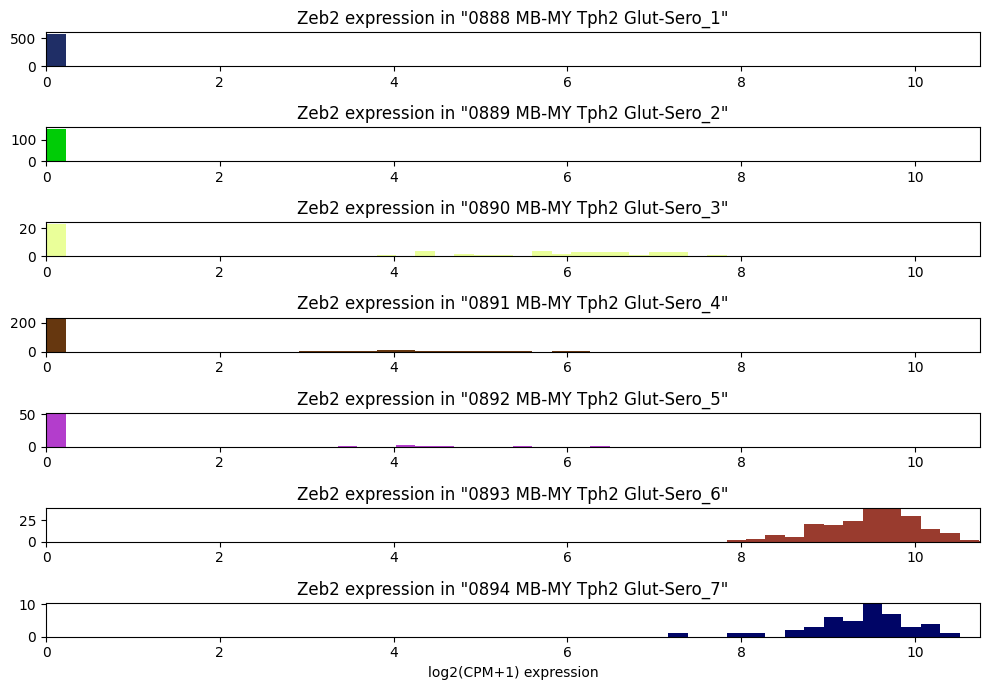

In [41]:
# find bounds of Zeb2 expression
min_zeb2 = sero_adata.X[:, zeb2_idx].min()
max_zeb2 = sero_adata.X[:, zeb2_idx].max()
d_zeb2 = max_zeb2-min_zeb2

# determine how many unique supertypes are in the serotontergic dataset
unq_supertypes = np.unique(sero_adata.obs.supertype)
n_supertypes = len(unq_supertypes)

fig = plt.figure(figsize=(10, 1*n_supertypes))

# add a sub plot for each supertype
axis_list = [
    fig.add_subplot(n_supertypes, 1, ii+1)
    for ii in range(n_supertypes)
]

# loop over supertypes
for supertype, axis in zip(unq_supertypes, axis_list):
    # grab only cells in this supertype
    subset = sero_adata[sero_adata.obs.supertype==supertype, :]

    zeb2_expression = subset.X[:, zeb2_idx]

    _  = axis.hist(
        zeb2_expression,
        bins=np.linspace(min_zeb2, max_zeb2+0.02*d_zeb2, 50),
        color=subset.obs.supertype_color.iloc[0]
    )

    axis.set_title(f'Zeb2 expression in "{supertype}"')
    axis.set_xlim(min_zeb2, max_zeb2)

axis_list[-1].set_xlabel('log2(CPM+1) expression')
fig.tight_layout()

Here we see that both of our supertypes of interest show consistently higher expression in Zeb2 than the other supertypes. ABC Atlas confirms this finding, as we can see [with this visualization](https://knowledge.brain-map.org/abcatlas#AQIBQVA4Sk5ONUxZQUJHVk1HS1kxQgACUTFOQ1dXUEc2RlowRE5JWEpCUQADAQE0TVY3SEE1REcyWEpaM1VEOEc5AAIBU2VybwAABAEBAnrqu0B%2F9cUaA4FUr%2F%2BCQp1IAAUABgEBAjE1Qks0N0RDSU9GMVNMTFVXOVAAA34AAAAEAAAIRzRJNEdGSlhKQjlBVFozUFRYMQAJTFZEQkpBVzhCSTVZU1MxUVVCRwAKAAsBbm9uZQACbm9uZQADAQQBAAIjMDAwMDAwAAPIAQAFAQECIzAwMDAwMAADyAEAAAABQVA4Sk5ONUxZQUJHVk1HS1kxQgACUTFOQ1dXUEc2RlowRE5JWEpCUQADAQE0TVY3SEE1REcyWEpaM1VEOEc5AAIBU2VybwAABAEBAnrqu0B%2F9cUaA4FUr%2F%2BCQp1IAAUBAVplYjIAAAYBAAJaZWIyAAN%2BAAAABAAFgPjZRIIEdcIGooEBBwIjRkZGRkZGAAMABkdFTkUABwAIAQkAAAAIRzRJNEdGSlhKQjlBVFozUFRYMQAJTFZEQkpBVzhCSTVZU1MxUVVCRwAKAAsBbm9uZQACbm9uZQADAQQBAAIjMDAwMDAwAAPIAQAFAQECIzAwMDAwMAADyAEAAAACAwA%3D) (the left panel colors all serotonergic cells by supertype; the right panel colors them by Zeb2 expression).

## What about "0894 MB-MY Tph2 Glut-Sero_7"?

It appears above that Zeb2 is a good marker for both "0893 MB-MY Tph2 Glut-Sero_6" and "0894 MB-MY Tph2 Glut-Sero_7", but what distinguishes those supertypes from each other. Let us recapitulate the analysis above, this time comparing those two supertypes.

In [42]:
wilcoxon = scipy.stats.ranksums(subset_0893.X, subset_0894.X, axis=0)

In [43]:
mu_0894 = subset_0894.X.mean(axis=0)
delta = mu_0894-mu_0893

In [44]:
valid = np.logical_and(
    wilcoxon.pvalue<0.01,
    delta>5.0
)

In [45]:
valid_delta = delta[valid]
valid_genes = subset_0894.var.gene_symbol.values[valid]

In [46]:
valid_genes[np.argmax(valid_delta)]

'C1ql3'

In [47]:
# figure out which column is C1ql3 in the full serotonergic AnnData object

c1ql3_idx = np.where(sero_adata.var.gene_symbol=='C1ql3')[0][0]

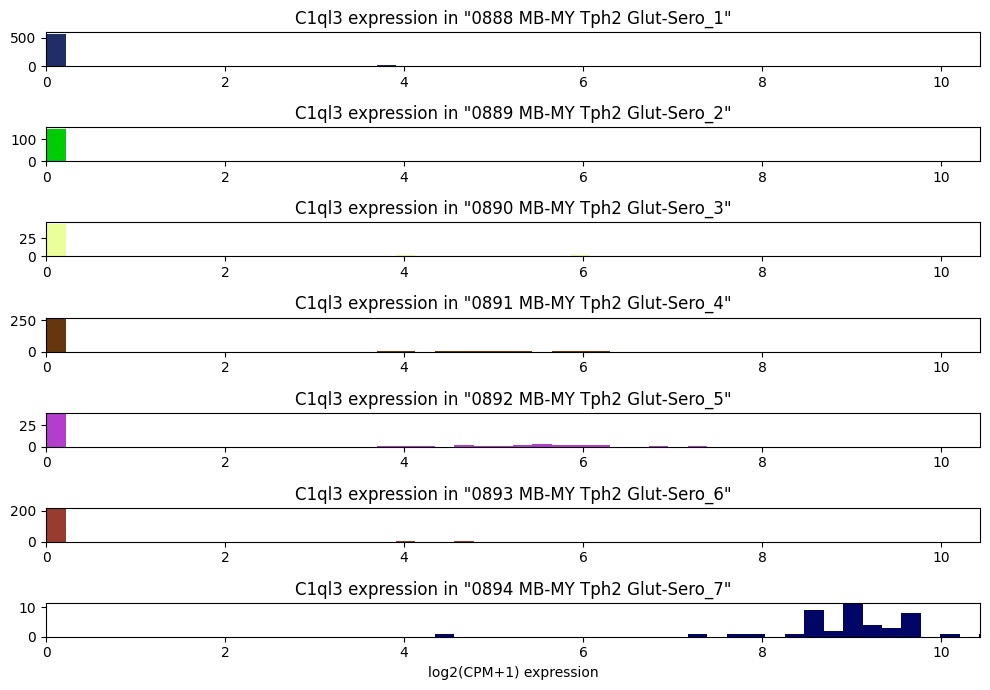

In [48]:
# find bounds of C1ql3 expression
min_c1ql3 = sero_adata.X[:, c1ql3_idx].min()
max_c1ql3 = sero_adata.X[:, c1ql3_idx].max()
d_c1ql3 = max_c1ql3-min_c1ql3

# determine how many unique supertypes are in the serotontergic dataset
unq_supertypes = np.unique(sero_adata.obs.supertype)
n_supertypes = len(unq_supertypes)

fig = plt.figure(figsize=(10, 1*n_supertypes))

# add a sub plot for each supertype
axis_list = [
    fig.add_subplot(n_supertypes, 1, ii+1)
    for ii in range(n_supertypes)
]

# loop over supertypes
for supertype, axis in zip(unq_supertypes, axis_list):
    # grab only cells in this supertype
    subset = sero_adata[sero_adata.obs.supertype==supertype, :]

    c1ql3_expression = subset.X[:, c1ql3_idx]

    _  = axis.hist(
        c1ql3_expression,
        bins=np.linspace(min_c1ql3, max_c1ql3+0.02*d_c1ql3, 50),
        color=subset.obs.supertype_color.iloc[0]
    )

    axis.set_title(f'C1ql3 expression in "{supertype}"')
    axis.set_xlim(min_c1ql3, max_c1ql3)

axis_list[-1].set_xlabel('log2(CPM+1) expression')
fig.tight_layout()

It appears that C1ql3 is only highly expressed in "0894 MB-MY Tph2 Glut-Sero_7".

Again: ABC Atlas [confirms this finding](https://knowledge.brain-map.org/abcatlas#AQIBQVA4Sk5ONUxZQUJHVk1HS1kxQgACUTFOQ1dXUEc2RlowRE5JWEpCUQADAQE0TVY3SEE1REcyWEpaM1VEOEc5AAIBU2VybwAABAEBAnrqu0B%2F9cUaA4FUr%2F%2BCQp1IAAUABgEBAjE1Qks0N0RDSU9GMVNMTFVXOVAAA34AAAAEAAAIRzRJNEdGSlhKQjlBVFozUFRYMQAJTFZEQkpBVzhCSTVZU1MxUVVCRwAKAAsBbm9uZQACbm9uZQADAQQBAAIjMDAwMDAwAAPIAQAFAQECIzAwMDAwMAADyAEAAAABQVA4Sk5ONUxZQUJHVk1HS1kxQgACUTFOQ1dXUEc2RlowRE5JWEpCUQADAQE0TVY3SEE1REcyWEpaM1VEOEc5AAIBU2VybwAABAEBAnrqu0B%2F9cUaA4FUr%2F%2BCQp1IAAUBAUMxcWwzAAAGAQACQzFxbDMAA34AAAAEAAWAfppYggAmxAbIrgEHAiNGRkZGRkYAAwAGR0VORQAHAAgBCQAAAAhHNEk0R0ZKWEpCOUFUWjNQVFgxAAlMVkRCSkFXOEJJNVlTUzFRVUJHAAoACwFub25lAAJub25lAAMBBAEAAiMwMDAwMDAAA8gBAAUBAQIjMDAwMDAwAAPIAQAAAAIDAA%3D%3D).

# Conclusion

This notebook was meant as a summary of how one could
- download cell-by-gene data of interest using `abc_atlas_access`
- analyze the data once downloaded
- visualize the results of the analysis

There is a large community of scientists and engineers who are experts on both ABC Atlas and `abc_atlas_access` at the Allen Institute. If you have any questions about how to use these tools, you might try consulting the appropriate [Allen Community Forum topic](https://community.brain-map.org/c/how-to/abc-atlas/19). It is possible your question has already been asked (and if it hasn't, you can ask it and the appropriate people step up and answer).